# Exercise 7

Alissa Trujillo<br>
July 19, 2022<br>
DSC 530<br>
Week 7: Regression

## Exercise 9-1

**Run the tests in this chapter with a different subset of data:**

In [ ]:
import nsfg
import thinkstats2
import hypothesis

In [2]:
from nsfg import ReadFemPreg

df = ReadFemPreg()
live = df[df.outcome == 1]

In [3]:
from hypothesis import DiffMeansPermute
from hypothesis import CorrelationPermute
from hypothesis import PregLengthTest

**Test 1: Comparing Pregnancy Lengths**

In [4]:
def ComparePregLength(firsts, others, iters):
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters = iters)
    
    return(p1)

**Test 2: Difference in Mean Birth Weight**

In [5]:
def CompareBirthWeight(firsts, others, iters):
    data = (firsts.totalwgt_lb.dropna().values, 
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters = iters)
    
    return p2

**Test 3: Correlation Between Age and Birthweight**

In [6]:
def TestCorrelation(live, iters):
    live2 = live.dropna(subset = ['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters = iters)
    
    return p3

**Test 4: Comparing Pregnancy Lengths (Chi-Squared)**

In [7]:
def ComparePregLengthChiSq(firsts, others, iters):
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters = iters)
    
    return p4

**Results:**

In [8]:
def RunTests(live, iters = 1000):
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]
    
    p1 = ComparePregLength(firsts, others, iters)
    p2 = CompareBirthWeight(firsts, others, iters)
    p3 = TestCorrelation(live, iters)
    p4 = ComparePregLengthChiSq(firsts, others, iters)
    print("n: " + str(n) + ", p1: " + str(p1) + ", p2: " + str(p2) + 
         ", p3: " + str(p3) + ", p4: " + str(p4))

In [9]:
n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample, iters = 1000)
    n //= 2

n: 9148, p1: 0.18, p2: 0.0, p3: 0.0, p4: 0.0
n: 4574, p1: 0.791, p2: 0.0, p3: 0.0, p4: 0.0
n: 2287, p1: 0.454, p2: 0.216, p3: 0.001, p4: 0.003
n: 1143, p1: 0.35, p2: 0.024, p3: 0.057, p4: 0.448
n: 571, p1: 0.829, p2: 0.171, p3: 0.004, p4: 0.382
n: 285, p1: 0.709, p2: 0.132, p3: 0.682, p4: 0.068
n: 142, p1: 0.762, p2: 0.387, p3: 0.045, p4: 0.874


**Analysis:**

As the sample sizes decrease, the p-values sharply increase as we do not have a representative enough sample to draw conclusions. We cannot make confident statemenets about the difference in means between first babie and others, or whether there is a true effet on a mother's age on birth weight. Without a large and representative sample, any statistics we calculate will not be significant enough to find an effect.

## Exercise 10-1

Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?
Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence in‐ terval. How much does correct weighting affect the estimates?

In [10]:
import brfss
import thinkplot
import numpy as np
import pandas as pd

In [11]:
df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [12]:
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.993080416391812, 0.005281454169417809)

**Correlation between height and log weight:**

In [16]:
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983437

**Coefficient of Determination:**

In [17]:
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.28273494311894065

**Verify that R^2 = rho^2**

In [18]:
np.isclose(rho**2, r2)

True

**Std(ys) is the RMSE of predictions not using height**

In [19]:
std_ys = thinkstats2.Std(log_weights)
std_ys

0.103207250300049

**Std(res) is the RMSE of predictions using height**

In [20]:
std_res = thinkstats2.Std(res)
std_res

0.0874077708041609

**How much is RMSE reduced when we introduce height information?**

In [21]:
1 - std_res / std_ys

0.15308497658793452

**Resampling:**

In [22]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

**Plotting the Sampling Distribution of the Slope**

{'xscale': 'linear', 'yscale': 'linear'}

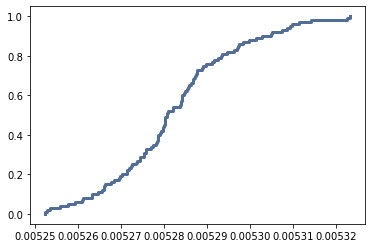

In [23]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

**Computing the p-value**

In [24]:
pvalue = cdf[0]
pvalue

0

**Computing the Confidence Interval (90%)**

In [25]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.0052576593517550995, 0.005309167256407781)

**Computing the Mean of the Sampling Distribution**

In [26]:
mean = thinkstats2.Mean(slope)
mean

0.005281454169417809

**Computing the Standard Error**

In [27]:
stderr = thinkstats2.Std(slopes)
stderr

1.474214060282235e-05

**Resample Without Weights**

In [28]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]

mean2 = thinkstats2.Mean(estimates_unweighted)
stderr2 = thinkstats2.Std(estimates_unweighted)
cdf2 = thinkstats2.Cdf(estimates_unweighted)
ci2 = cdf2.Percentile(5), cdf2.Percentile(95)

print("Mean: " + str(mean2) + ", Standard Error: " + str(stderr2) + 
     ", CI: " + str(ci2))

Mean: 168.95713929141658, Standard Error: 0.015917030166560913, CI: (168.93007639604681, 168.98158309585884)


**Resample With Weights**

In [29]:
from thinkstats2 import ResampleRowsWeighted

estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]

mean3 = thinkstats2.Mean(estimates_weighted)
stderr3 = thinkstats2.Std(estimates_weighted)
cdf3 = thinkstats2.Cdf(estimates_weighted)
ci3 = cdf3.Percentile(5), cdf3.Percentile(95)

print("Mean: " + str(mean3) + ", Standard Error: " + str(stderr3) + 
     ", CI: " + str(ci3))

Mean: 170.49729183087777, Standard Error: 0.017158362414467457, CI: (170.46748115362072, 170.52410113381436)


**Results:**

After we weighted the sample, the mean height is roughly 2cm taller than the unweighted sample. When we look at the standard errors, we can see that 2cm is a significant difference that cannot be explained purely by randomness. The confidence intervals are also distinct and do not overlap at all.